In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics ,preprocessing
import pandas as pd
import itertools
import os
from sklearn.metrics import confusion_matrix


import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error
from keras.callbacks import Callback
from keras.layers import Conv1D, MaxPooling1D

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    'AccX',
    'AccY', 
    'AccZ', 
    'GyroX',
    'GyroY', 
    'GyroZ'
]

# Output classes to learn how to classify
LABELS = ['walking',
        'walking upstairs',
        'walking downstairs',
        'sitting',
        'standing',
        'laying']
RAW_DATA_PATH = "../G9_data/snippets/"
SUBJECT_LIST = [  1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26]
seed = 7
np.random.seed(seed)

## Utility functions for training:


In [12]:


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = 6
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [4]:
def load_data(Snippet_paths):
    X_signals = []
    y_signals = []
    usecols = INPUT_SIGNAL_TYPES + ['label']
    for snippet_path in Snippet_paths:
        df = pd.read_csv(snippet_path, usecols=usecols)
        y_signals.append(np.array(df['label'][0].reshape(1), dtype=np.int32))
        df = df[INPUT_SIGNAL_TYPES]
        c = df.values#.reshape(df.shape[0], df.shape[1])
        X_signals.append(c)
        
    return np.asarray(X_signals), np.asarray(y_signals)






In [5]:
subject_no = 17
Snippet_paths_train =[]
Snippet_paths_test =[]
for fol in LABELS:
    folder = RAW_DATA_PATH+'/'+fol+'/'  # folder = RAW_DATA_PATH+'/'+fol+'/'
    for root,dirs,files in os.walk(folder):
        for file_ in files:
            if file_.endswith(".csv"):
                if int(file_.split("_")[0]) != subject_no:
                    Snippet_paths_train.append(folder+file_)
                elif int(file_.split("_")[0]) == subject_no:
                    Snippet_paths_test.append(folder+file_)

In [6]:
X_train,y_train = load_data(Snippet_paths_train)

X_test,y_test = load_data(Snippet_paths_test)

y_test = y_test - 1
y_train = y_train - 1

In [8]:
X_train_padded.shape

(23989, 128, 6)

In [12]:
X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=128, dtype='float64',
    padding='pre', truncating='pre', value=0.)
X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=128, dtype='float64',
    padding='pre', truncating='pre', value=0.)

In [12]:
# Scaling
X_train_2d = X_train_padded.transpose(2,0,1).reshape(6,-1).transpose()
X_test_2d = X_test_padded.transpose(2,0,1).reshape(6,-1).transpose()
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X_train_2d)
X_train_scaled =  np.array([scaler.transform(X_train_padded[i,:,:]) for i in range(X_train_padded.shape[0])])
X_test_scaled  =  np.array([scaler.transform(X_test_padded[i,:,:]) for i in range(X_test_padded.shape[0])])

In [9]:
X_loaded = np.load("../X.npy")
y_loaded = np.load("../y.npy")

In [13]:
# Scaling
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True).fit(X_train_2d)
X_train_scaled =  np.array([scaler.transform(X_train_padded[i,:,:]) for i in range(X_train_padded.shape[0])])
X_test_scaled  =  np.array([scaler.transform(X_test_padded[i,:,:]) for i in range(X_test_padded.shape[0])])


In [14]:
X_train_used = np.concatenate([X_train_scaled, X_loaded])
y_train_used = np.concatenate([y_train, y_loaded])
X_test_used = X_test_scaled

In [13]:
X_train_used = X_train_padded[:,:,0]
X_test_used = X_test_padded[:,:,0]

In [14]:
X_train_used.shape, y_train.shape, X_test_used.shape, y_test.shape

((23989, 128), (23989, 1), (1039, 128), (1039, 1))

In [15]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([145,  75,  72, 374, 183, 190]))

## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [7]:
# Input Data 

training_data_count = len(X_train_used)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test_used)  # 2947 testing series
 
timesteps = len(X_train_used[0]) # 128 timesteps per series
# input_dim = len(X_train_used[0][0]) # 6 input parameters per timestep

# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300
# Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X test shape, y test shape, every X's mean, every X's standard deviation)")
print(X_test_used.shape, y_test.shape, np.mean(X_test_used), np.std(X_test_used))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X test shape, y test shape, every X's mean, every X's standard deviation)
(100, 128, 1) (100, 1) 0.49970266846807626 0.2907379356536168
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [29]:


model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(timesteps, input_dim)))
model.add(LSTM(32))
model.add(Dropout(0.7))
model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history =model.fit(X_train_used,
          one_hot(y_train_used),
          batch_size=batch_size,
          validation_data=(X_test_used, one_hot(y_test)),
          epochs=100)


# Evaluate
predictions = model.predict(X_test_used).argmax(1)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))


Train on 34288 samples, validate on 1039 samples
Epoch 1/100
34288/34288 [==============================] - 11s 329us/step - loss: 1.6838 - acc: 0.3148 - val_loss: 1.4304 - val_acc: 0.5650
Epoch 2/100
34288/34288 [==============================] - 10s 302us/step - loss: 1.4581 - acc: 0.3835 - val_loss: 1.2749 - val_acc: 0.5833
Epoch 3/100
34288/34288 [==============================] - 11s 313us/step - loss: 1.3544 - acc: 0.4122 - val_loss: 1.1961 - val_acc: 0.6439
Epoch 4/100
34288/34288 [==============================] - 11s 313us/step - loss: 1.3128 - acc: 0.4317 - val_loss: 1.1721 - val_acc: 0.6343
Epoch 5/100
34288/34288 [==============================] - 10s 303us/step - loss: 1.2743 - acc: 0.4591 - val_loss: 1.1293 - val_acc: 0.6574
Epoch 6/100
34288/34288 [==============================] - 11s 308us/step - loss: 1.2482 - acc: 0.4791 - val_loss: 1.0784 - val_acc: 0.6882
Epoch 7/100
34288/34288 [==============================] - 11s 307us/step - loss: 1.2232 - acc: 0.4957 - val_lo

Epoch 59/100
34288/34288 [==============================] - 10s 302us/step - loss: 0.7452 - acc: 0.6767 - val_loss: 0.5893 - val_acc: 0.7469
Epoch 60/100
34288/34288 [==============================] - 11s 317us/step - loss: 0.7395 - acc: 0.6809 - val_loss: 0.5873 - val_acc: 0.7536
Epoch 61/100
34288/34288 [==============================] - 11s 306us/step - loss: 0.7424 - acc: 0.6798 - val_loss: 0.6113 - val_acc: 0.7517
Epoch 62/100
34288/34288 [==============================] - 10s 301us/step - loss: 0.7302 - acc: 0.6830 - val_loss: 0.6739 - val_acc: 0.6853
Epoch 63/100
34288/34288 [==============================] - 10s 306us/step - loss: 0.7334 - acc: 0.6873 - val_loss: 0.6701 - val_acc: 0.7113
Epoch 64/100
34288/34288 [==============================] - 11s 308us/step - loss: 0.7311 - acc: 0.6840 - val_loss: 0.6293 - val_acc: 0.7526
Epoch 65/100
34288/34288 [==============================] - 11s 310us/step - loss: 0.7226 - acc: 0.6880 - val_loss: 0.6431 - val_acc: 0.7392
Epoch 66/100


In [17]:
X_train_used = X_train_used.reshape(X_train_used.shape[0],X_train_used.shape[1],1 )
X_test_used = X_test_used.reshape(X_test_used.shape[0],X_test_used.shape[1],1 )

In [8]:
timesteps

128

In [20]:
X_train_used = np.random.random((10000,128,1))
y_train = np.random.randint(low = 0,high=5, size=(10000, 1))
X_test_used = np.random.random((100,128,1))
y_test =  np.random.randint(low = 0,high=5, size=(100, 1))
print("(X train shape, y train shape,X test shape, y test shape)")
print(X_train_used.shape, y_train.shape,X_test_used.shape, y_test.shape)

(X train shape, y train shape,X test shape, y test shape)
(10000, 128, 1) (10000, 1) (100, 128, 1) (100, 1)


In [22]:
np.save('X_train.npy', X_train_used)
np.save('y_train.npy', y_train)

In [23]:
model = Sequential()
model.add(Conv1D(64,
                 5,
                 input_shape=(timesteps,1),
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(128,
                 3,
                 input_shape=(timesteps,1),
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=3))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(n_classes, activation='sigmoid'))

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 124, 64)           384       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 41, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 39, 128)           24704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 13, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 13, 32)            20608     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total para

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history =model.fit(X_train_used,
          one_hot(y_train),
          batch_size=batch_size,
          validation_data=(X_test_used, one_hot(y_test)),
          epochs=100)


# Evaluate
predictions = model.predict(X_test_used).argmax(1)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

Train on 10000 samples, validate on 100 samples
Epoch 1/100
10000/10000 [==============================] - 1s 131us/step - loss: 1.7201 - acc: 0.2000 - val_loss: 1.6310 - val_acc: 0.2500
Epoch 2/100
10000/10000 [==============================] - 0s 44us/step - loss: 1.6253 - acc: 0.1945 - val_loss: 1.6158 - val_acc: 0.2500
Epoch 3/100
10000/10000 [==============================] - 0s 46us/step - loss: 1.6168 - acc: 0.1907 - val_loss: 1.6199 - val_acc: 0.1900
Epoch 4/100
10000/10000 [==============================] - 0s 46us/step - loss: 1.6141 - acc: 0.1971 - val_loss: 1.6117 - val_acc: 0.1900
Epoch 5/100
10000/10000 [==============================] - 0s 49us/step - loss: 1.6127 - acc: 0.2031 - val_loss: 1.6188 - val_acc: 0.1800
Epoch 6/100
10000/10000 [==============================] - 0s 46us/step - loss: 1.6122 - acc: 0.1943 - val_loss: 1.6115 - val_acc: 0.1900
Epoch 7/100
10000/10000 [==============================] - 0s 44us/step - loss: 1.6119 - acc: 0.1943 - val_loss: 1.6125 - v

In [25]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [31]:
model.weights

[<tf.Variable 'conv1d_2/kernel:0' shape=(5, 1, 64) dtype=float32_ref>,
 <tf.Variable 'conv1d_2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'conv1d_3/kernel:0' shape=(3, 64, 128) dtype=float32_ref>,
 <tf.Variable 'conv1d_3/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'lstm_2/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'lstm_2/recurrent_kernel:0' shape=(32, 128) dtype=float32_ref>,
 <tf.Variable 'lstm_2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'lstm_3/kernel:0' shape=(32, 128) dtype=float32_ref>,
 <tf.Variable 'lstm_3/recurrent_kernel:0' shape=(32, 128) dtype=float32_ref>,
 <tf.Variable 'lstm_3/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(32, 6) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(6,) dtype=float32_ref>]

dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


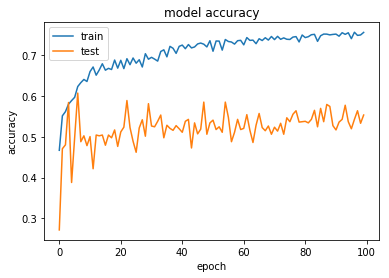

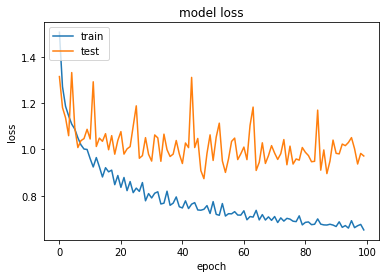

In [24]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## And finally, the multi-class confusion matrix and metrics!


Precision: 75.2202957247%
Recall: 76.9971126083%
f1_score: 75.5165886308%

Confusion Matrix:
[[ 80   7  26  17  14   1]
 [ 66   4   5   0   0   0]
 [ 37   2  27   4   2   0]
 [  5   2   0 342   4  21]
 [  5   2   7   6 162   1]
 [  0   0   0   5   0 185]]

Confusion matrix (normalised to % of total test data):
[[0.55172414 0.04827586 0.17931034 0.11724138 0.09655172 0.00689655]
 [0.88       0.05333333 0.06666667 0.         0.         0.        ]
 [0.51388889 0.02777778 0.375      0.05555556 0.02777778 0.        ]
 [0.01336898 0.00534759 0.         0.9144385  0.01069519 0.05614973]
 [0.0273224  0.01092896 0.03825137 0.03278689 0.8852459  0.00546448]
 [0.         0.         0.         0.02631579 0.         0.97368421]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


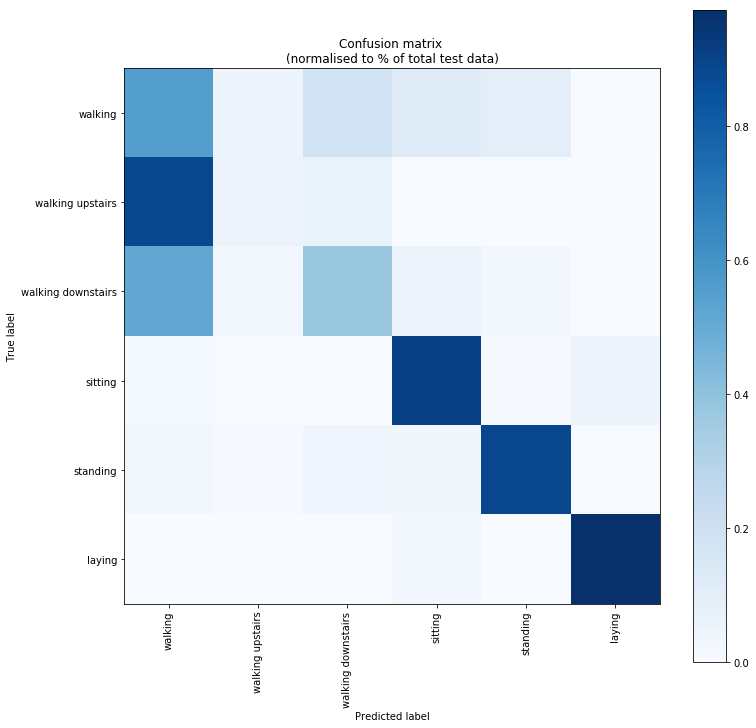

In [23]:
# Results




print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.savefig("Results/LSTM_loaded_data.jpg")
plt.show()

Normalized confusion matrix


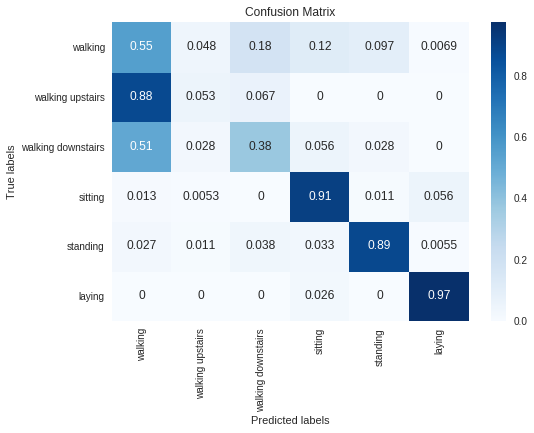

In [26]:
plot_cm(confusion_matrix, LABELS)

In [25]:
def plot_cm(cm, classes, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="Blues"); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes[::-1]);
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,target_names=LABELS))

                    precision    recall  f1-score   support

           walking       0.41      0.55      0.47       145
  walking upstairs       0.24      0.05      0.09        75
walking downstairs       0.42      0.38      0.39        72
           sitting       0.91      0.91      0.91       374
          standing       0.89      0.89      0.89       183
            laying       0.89      0.97      0.93       190

       avg / total       0.75      0.77      0.76      1039



In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 32)           4992      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 13,510
Trainable params: 13,510
Non-trainable params: 0
_________________________________________________________________
